In [3]:
import os
print(os.getcwd())

/Users/seokhyunyoon/ad-campaign-roas-optimizer


In [4]:
# source ~/.virtualenvs/r-reticulate/bin/activate  
# https://www.kaggle.com/datasets/loveall/clicks-conversion-tracking : data source
import pandas as pd

df = pd.read_csv('conversion_data.csv')
print(df.head())



    ad_id  xyz_campaign_id  fb_campaign_id    age gender  interest  \
0  708746              916          103916  30-34      M        15   
1  708749              916          103917  30-34      M        16   
2  708771              916          103920  30-34      M        20   
3  708815              916          103928  30-34      M        28   
4  708818              916          103928  30-34      M        28   

   Impressions  Clicks  Spent  Total_Conversion  Approved_Conversion  
0         7350       1   1.43                 2                    1  
1        17861       2   1.82                 2                    0  
2          693       0   0.00                 1                    0  
3         4259       1   1.25                 1                    0  
4         4133       1   1.29                 1                    1  


In [5]:
# checking null value
print(df.isnull().sum())

ad_id                  0
xyz_campaign_id        0
fb_campaign_id         0
age                    0
gender                 0
interest               0
Impressions            0
Clicks                 0
Spent                  0
Total_Conversion       0
Approved_Conversion    0
dtype: int64


In [6]:
import numpy as np
import pandas as pd

# Feature Engineering for Ad Campaign Dataset

# Avoid division by zero by replacing 0 with np.nan, then fill NaN with 0 at the end

# Click-Through Rate (CTR)
df['CTR'] = df['Clicks'] / df['Impressions'].replace(0, np.nan)

# Conversion Rate (per click)
df['Conversion_Rate'] = df['Total_Conversion'] / df['Clicks'].replace(0, np.nan)

# Approved Conversion Rate (per click)
df['Approved_Conversion_Rate'] = df['Approved_Conversion'] / df['Clicks'].replace(0, np.nan)

# Cost Per Click (CPC)
df['CPC'] = df['Spent'] / df['Clicks'].replace(0, np.nan)

# Cost Per Conversion
df['Cost_Per_Conversion'] = df['Spent'] / df['Total_Conversion'].replace(0, np.nan)

# Cost Per Approved Conversion
df['Cost_Per_Approved_Conversion'] = df['Spent'] / df['Approved_Conversion'].replace(0, np.nan)

# Estimated Revenue (set your own value per conversion if known)
conversion_value = 100  # Example: $100 per approved conversion
df['Estimated_Revenue'] = df['Approved_Conversion'] * conversion_value

# ROAS (Return on Ad Spend)
df['ROAS'] = df['Estimated_Revenue'] / df['Spent'].replace(0, np.nan)

# Impressions per Dollar Spent
df['Impressions_per_Dollar'] = df['Impressions'] / df['Spent'].replace(0, np.nan)

# Clicks per Approved Conversion
df['Clicks_per_Approved_Conversion'] = df['Clicks'] / df['Approved_Conversion'].replace(0, np.nan)

# Impressions per Conversion
df['Impressions_per_Conversion'] = df['Impressions'] / df['Total_Conversion'].replace(0, np.nan)


# Clean up any inf or NaN values
df = df.replace([np.inf, -np.inf], np.nan)
df = df.fillna(0)

#Convert categorical columns
categorical_cols = ['age', 'gender', 'interest']
for col in categorical_cols:
    df[col] = df[col].astype('category')


In [7]:
# Define X and y
exclude_cols = ['ad_id', 'xyz_campaign_id', 'fb_campaign_id']  # plus any columns you don't want as features
X = df.drop(columns=exclude_cols + ['ROAS'])  # assuming ROAS is your target
y = df['ROAS']


# Split data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
# 3. Initialize XGBoost model
from xgboost import XGBRegressor
model = XGBRegressor(
    enable_categorical=True,
    tree_method='hist',
    random_state=42
)

In [9]:
from sklearn.model_selection import GridSearchCV 
from xgboost import XGBRegressor

# 1. Define model
model = XGBRegressor(
    enable_categorical=True,
    tree_method='hist',
    random_state=42
)

# 2. Correct parameter grid (remove 'regressor__' prefix)
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8],
    'colsample_bytree': [0.6, 0.8]
}

# 3. Fixed GridSearchCV call
grid = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_absolute_error',
    verbose=1,
    n_jobs=-1
)

grid.fit(X_train, y_train)


Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=True, eval_metric=None,
                                    feature_types=None, feature_weights=None,
                                    gamma=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.6, 0.8],
                         'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [3, 5, 7], 'subsample': [0.6, 0.8]},
             scoring='neg_mean_absolute_error', verbose=1)

In [10]:
from sklearn.metrics import mean_absolute_error, r2_score

# Get best model from grid search
best_model = grid.best_estimator_

# Make predictions
y_pred = best_model.predict(X_test)

# Evaluate
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Test MAE: {mae}')
print(f'Test R²: {r2}')


Test MAE: 1.1742973485222046
Test R²: 0.9163353279835191


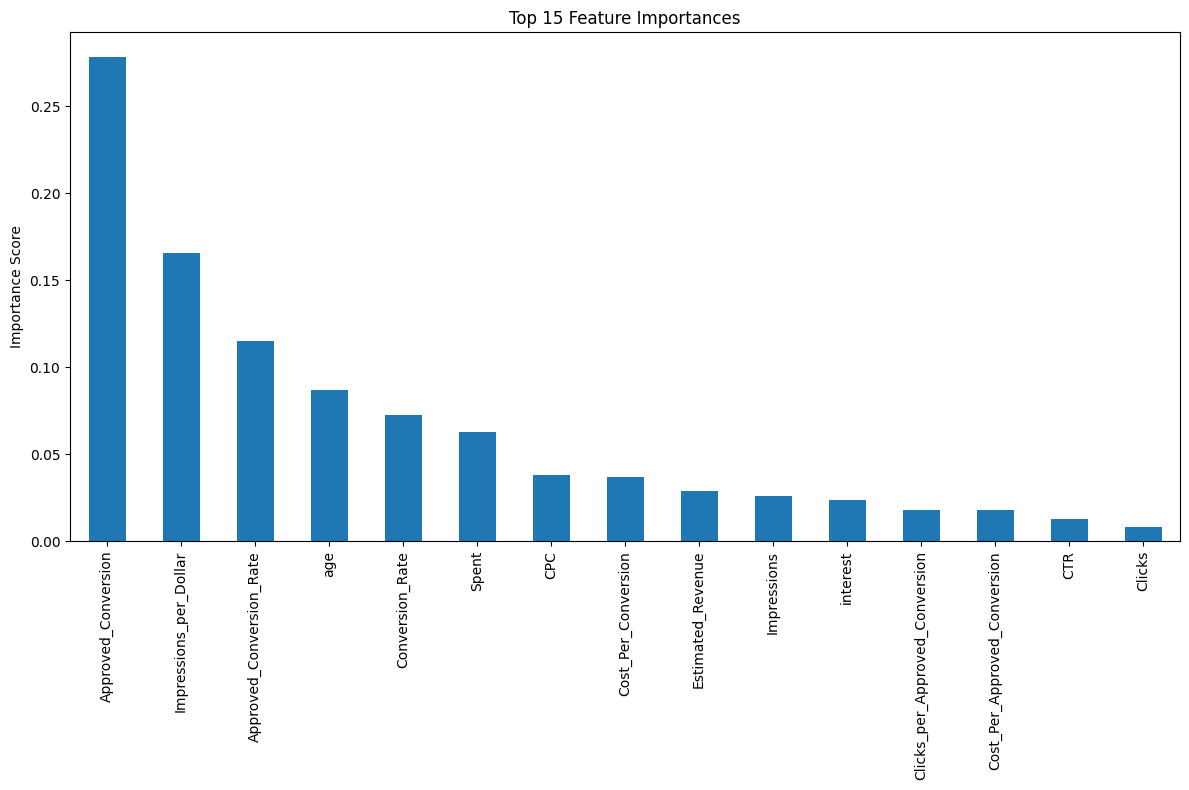

In [11]:
# 6. Feature importance analysis
import matplotlib.pyplot as plt

importances = best_model.feature_importances_
feature_names = X.columns
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)

plt.figure(figsize=(12, 8))
feat_imp.head(15).plot(kind='bar')
plt.title('Top 15 Feature Importances')
plt.ylabel('Importance Score')
plt.tight_layout()
plt.show()

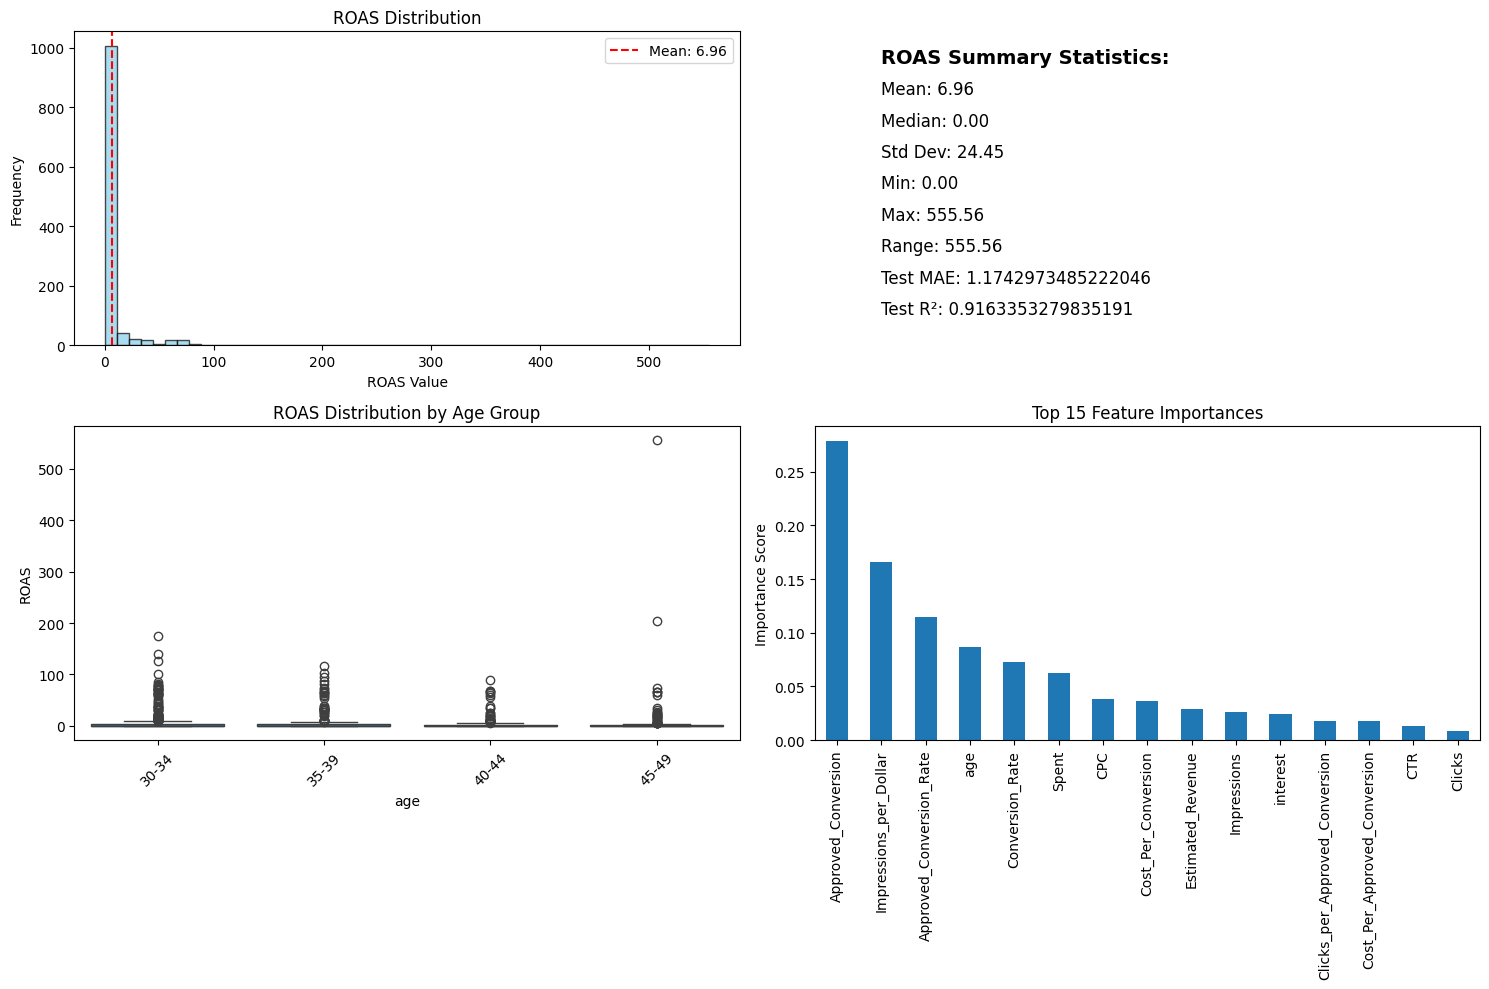

<Figure size 640x480 with 0 Axes>

In [12]:
# ROAS Visualization Orignal
import matplotlib.pyplot as plt
import seaborn as sns

# Create a comprehensive ROAS analysis plot
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. ROAS Distribution (Histogram)
axes[0,0].hist(df['ROAS'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0,0].set_title('ROAS Distribution')
axes[0,0].set_xlabel('ROAS Value')
axes[0,0].set_ylabel('Frequency')
axes[0,0].axvline(df['ROAS'].mean(), color='red', linestyle='--', label=f'Mean: {df["ROAS"].mean():.2f}')
axes[0,0].legend()

# 2. ROAS Box Plot
#axes[0,1].boxplot(df['ROAS'])
#axes[0,1].set_title('ROAS Box Plot (Outlier Detection)')
#axes[0,1].set_ylabel('ROAS Value')

# 3. ROAS by Campaign/Channel (if available)
if 'age' in df.columns:  # Using age as an example demographic
    sns.boxplot(data=df, x='age', y='ROAS', ax=axes[1,0])
    axes[1,0].set_title('ROAS Distribution by Age Group')
    axes[1,0].tick_params(axis='x', rotation=45)

# 4. ROAS Summary Statistics
axes[0,1].text(0.1, 0.9, f'ROAS Summary Statistics:', fontsize=14, fontweight='bold')
axes[0,1].text(0.1, 0.8, f'Mean: {df["ROAS"].mean():.2f}', fontsize=12)
axes[0,1].text(0.1, 0.7, f'Median: {df["ROAS"].median():.2f}', fontsize=12)
axes[0,1].text(0.1, 0.6, f'Std Dev: {df["ROAS"].std():.2f}', fontsize=12)
axes[0,1].text(0.1, 0.5, f'Min: {df["ROAS"].min():.2f}', fontsize=12)
axes[0,1].text(0.1, 0.4, f'Max: {df["ROAS"].max():.2f}', fontsize=12)
axes[0,1].text(0.1, 0.3, f'Range: {df["ROAS"].max() - df["ROAS"].min():.2f}', fontsize=12)

axes[0,1].text(0.1, 0.2, f'Test MAE: {mae}', fontsize=12)
axes[0,1].text(0.1, 0.1, f'Test R²: {r2}', fontsize=12)

axes[0,1].set_xlim(0, 1)
axes[0,1].set_ylim(0, 1)
axes[0,1].axis('off')

# 6. Feature importance analysis
import matplotlib.pyplot as plt

importances = best_model.feature_importances_
feature_names = X.columns
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)


feat_imp.head(15).plot(kind='bar')
plt.title('Top 15 Feature Importances')
plt.ylabel('Importance Score')
plt.tight_layout()
plt.show()


plt.tight_layout()
plt.show()


Test MAE: 1.1743
Test R²: 0.9163


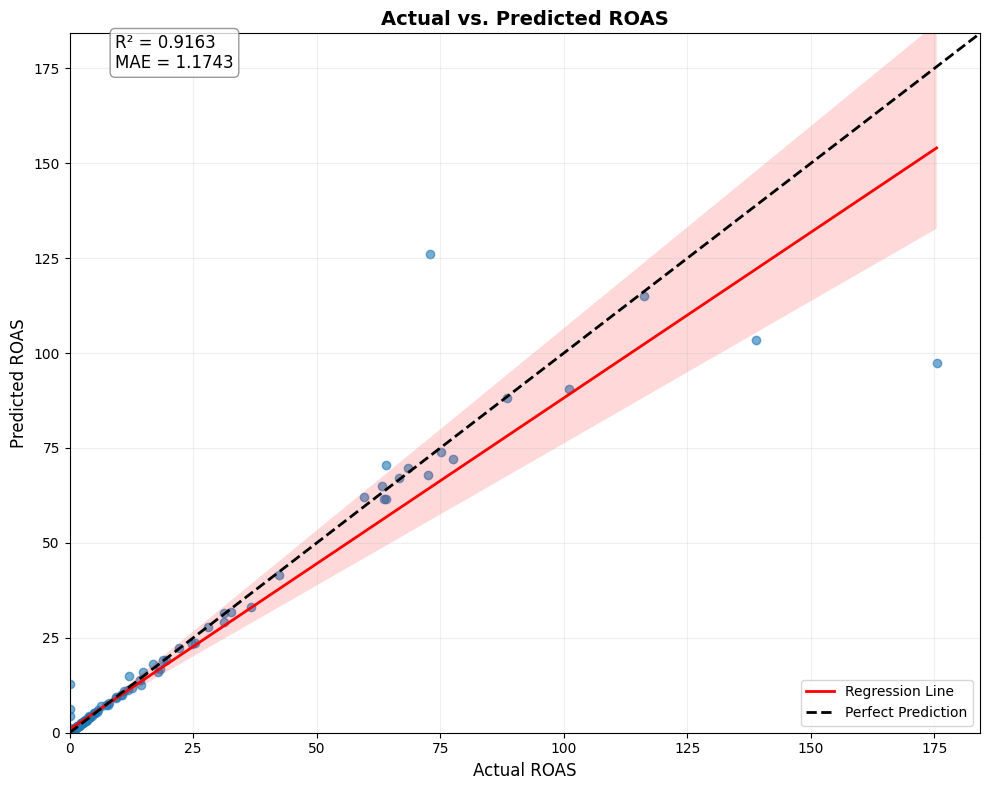

In [13]:
# Actual vs Prediction - Original
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Make predictions
y_pred = best_model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Test MAE: {mae:.4f}')
print(f'Test R²: {r2:.4f}')

# Plot: Actual vs Predicted ROAS
plt.figure(figsize=(10, 8))

# Scatter plot with regression line
sns.regplot(
    x=y_test,
    y=y_pred,
    scatter_kws={'alpha': 0.6, 'color': '#1f77b4'},
    line_kws={'color': 'red', 'lw': 2, 'label': 'Regression Line'}
)

# Diagonal perfect prediction line
max_val = max(y_test.max(), y_pred.max()) * 1.05
plt.plot([0, max_val], [0, max_val], 'k--', lw=2, label='Perfect Prediction')

# Axis labels and title
plt.xlabel('Actual ROAS', fontsize=12)
plt.ylabel('Predicted ROAS', fontsize=12)
plt.title('Actual vs. Predicted ROAS', fontsize=14, fontweight='bold')

# Annotate R²
plt.annotate(f'R² = {r2:.4f}\nMAE = {mae:.4f}',
             xy=(0.05, 0.95),
             xycoords='axes fraction',
             fontsize=12,
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

plt.xlim(0, max_val)
plt.ylim(0, max_val)
plt.grid(alpha=0.2)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

In [14]:
df[df['ROAS'] > 500]
df_out = df[df['ROAS'] < 500]
df_out[df_out['ROAS']>500]


,ad_id,xyz_campaign_id,fb_campaign_id,age,gender,interest,Impressions,Clicks,Spent,Total_Conversion,...,Conversion_Rate,Approved_Conversion_Rate,CPC,Cost_Per_Conversion,Cost_Per_Approved_Conversion,Estimated_Revenue,ROAS,Impressions_per_Dollar,Clicks_per_Approved_Conversion,Impressions_per_Conversion


In [15]:
# Recalculating R2 and MAE

# REDefine X and y
exclude_cols = ['ad_id', 'xyz_campaign_id', 'fb_campaign_id']  # plus any columns you don't want as features
X = df_out.drop(columns=exclude_cols + ['ROAS'])  # assuming ROAS is your target
y = df_out['ROAS']

# Grid search for data without outlier
from sklearn.model_selection import GridSearchCV 
from xgboost import XGBRegressor

# 1. Define model
model = XGBRegressor(
    enable_categorical=True,
    tree_method='hist',
    random_state=42
)

# 2. Correct parameter grid (remove 'regressor__' prefix)
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8],
    'colsample_bytree': [0.6, 0.8]
}

# 3. Fixed GridSearchCV call
grid = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_absolute_error',
    verbose=1,
    n_jobs=-1
)

grid.fit(X_train, y_train)


from sklearn.metrics import mean_absolute_error, r2_score

# Get best model from grid search
best_model = grid.best_estimator_

# Make predictions
y_pred = best_model.predict(X_test)

# Evaluate
mae_new = mean_absolute_error(y_test, y_pred)
r2_new = r2_score(y_test, y_pred)

print(f'Test MAE: {mae_new}')
print(f'Test R²: {r2_new}')



Fitting 5 folds for each of 36 candidates, totalling 180 fits
Test MAE: 1.1742973485222046
Test R²: 0.9163353279835191


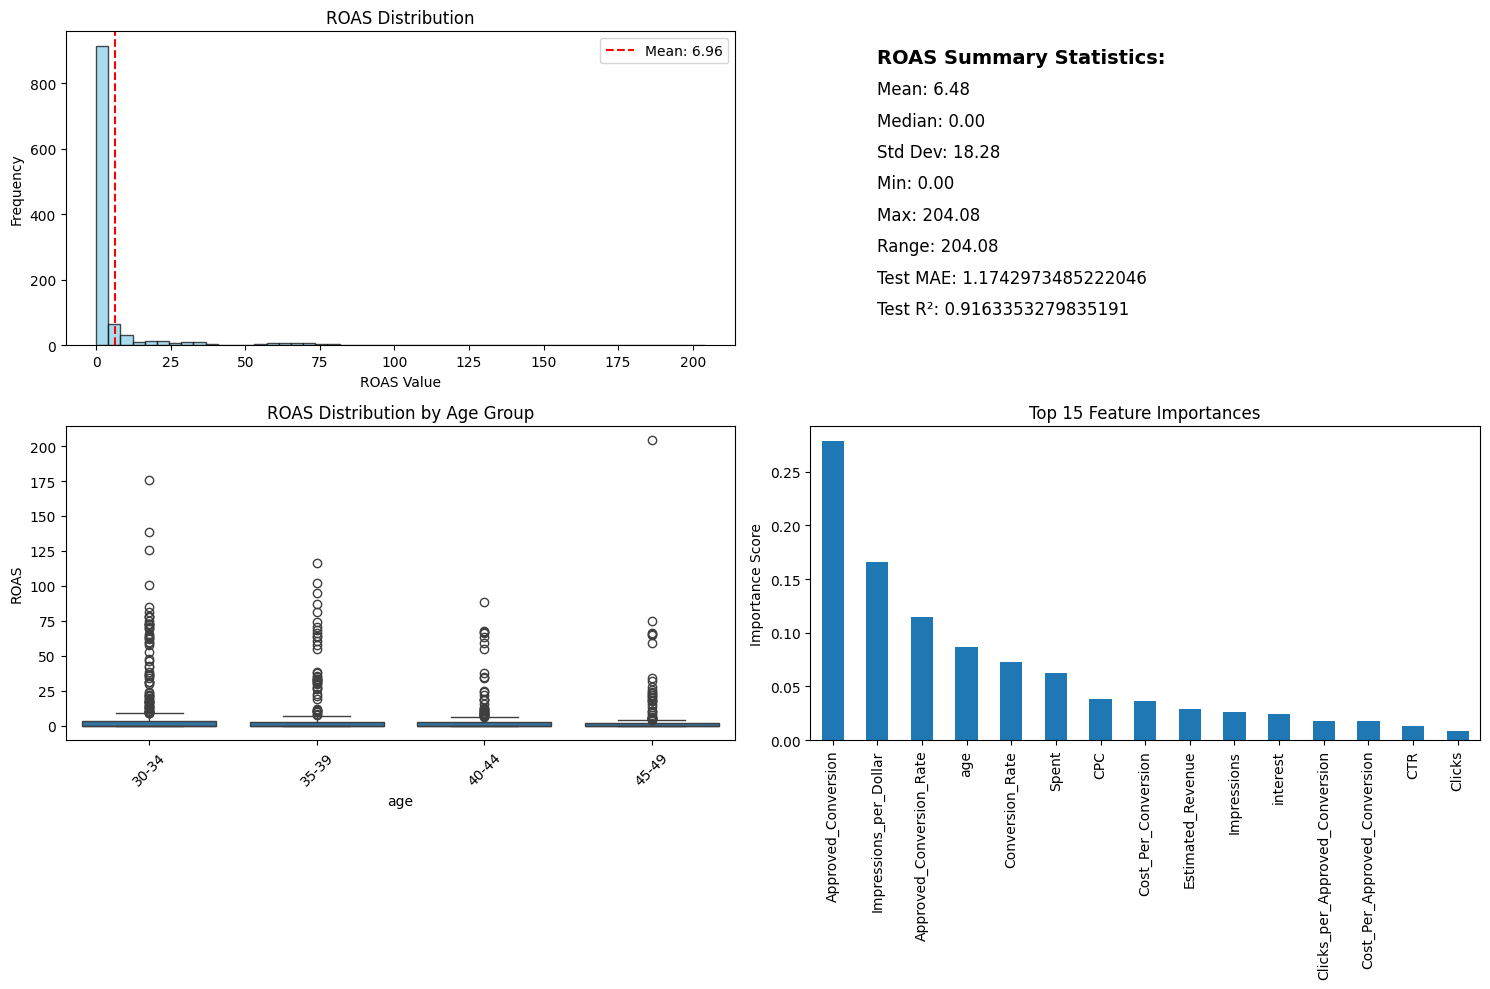

<Figure size 640x480 with 0 Axes>

In [16]:
# ROAS Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Create a comprehensive ROAS analysis plot
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. ROAS Distribution (Histogram)
axes[0,0].hist(df_out['ROAS'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0,0].set_title('ROAS Distribution')
axes[0,0].set_xlabel('ROAS Value')
axes[0,0].set_ylabel('Frequency')
axes[0,0].axvline(df_out['ROAS'].mean(), color='red', linestyle='--', label=f'Mean: {df["ROAS"].mean():.2f}')
axes[0,0].legend()

# 3. ROAS by Campaign/Channel (if available)
if 'age' in df_out.columns:  # Using age as an example demographic
    sns.boxplot(data=df_out, x='age', y='ROAS', ax=axes[1,0])
    axes[1,0].set_title('ROAS Distribution by Age Group')
    axes[1,0].tick_params(axis='x', rotation=45)

# 4. Caclulating the R^2 and MAE

best_model = grid.best_estimator_

# Make predictions
y_pred = best_model.predict(X_test)

mae_new = mean_absolute_error(y_test, y_pred)
r2_new = r2_score(y_test, y_pred)



# 4. ROAS Summary Statistics
axes[0,1].text(0.1, 0.9, f'ROAS Summary Statistics:', fontsize=14, fontweight='bold')
axes[0,1].text(0.1, 0.8, f'Mean: {df_out["ROAS"].mean():.2f}', fontsize=12)
axes[0,1].text(0.1, 0.7, f'Median: {df_out["ROAS"].median():.2f}', fontsize=12)
axes[0,1].text(0.1, 0.6, f'Std Dev: {df_out["ROAS"].std():.2f}', fontsize=12)
axes[0,1].text(0.1, 0.5, f'Min: {df_out["ROAS"].min():.2f}', fontsize=12)
axes[0,1].text(0.1, 0.4, f'Max: {df_out["ROAS"].max():.2f}', fontsize=12)
axes[0,1].text(0.1, 0.3, f'Range: {df_out["ROAS"].max() - df_out["ROAS"].min():.2f}', fontsize=12)

axes[0,1].text(0.1, 0.2, f'Test MAE: {mae_new}', fontsize=12)
axes[0,1].text(0.1, 0.1, f'Test R²: {r2_new}', fontsize=12)

axes[0,1].set_xlim(0, 1)
axes[0,1].set_ylim(0, 1)
axes[0,1].axis('off')


# 6. Feature importance analysis
import matplotlib.pyplot as plt

importances = best_model.feature_importances_
feature_names = X.columns
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)


feat_imp.head(15).plot(kind='bar')
plt.title('Top 15 Feature Importances')
plt.ylabel('Importance Score')
plt.tight_layout()
plt.show()


plt.tight_layout()
plt.show()


Test MAE: 0.5912
Test R²: 0.9280


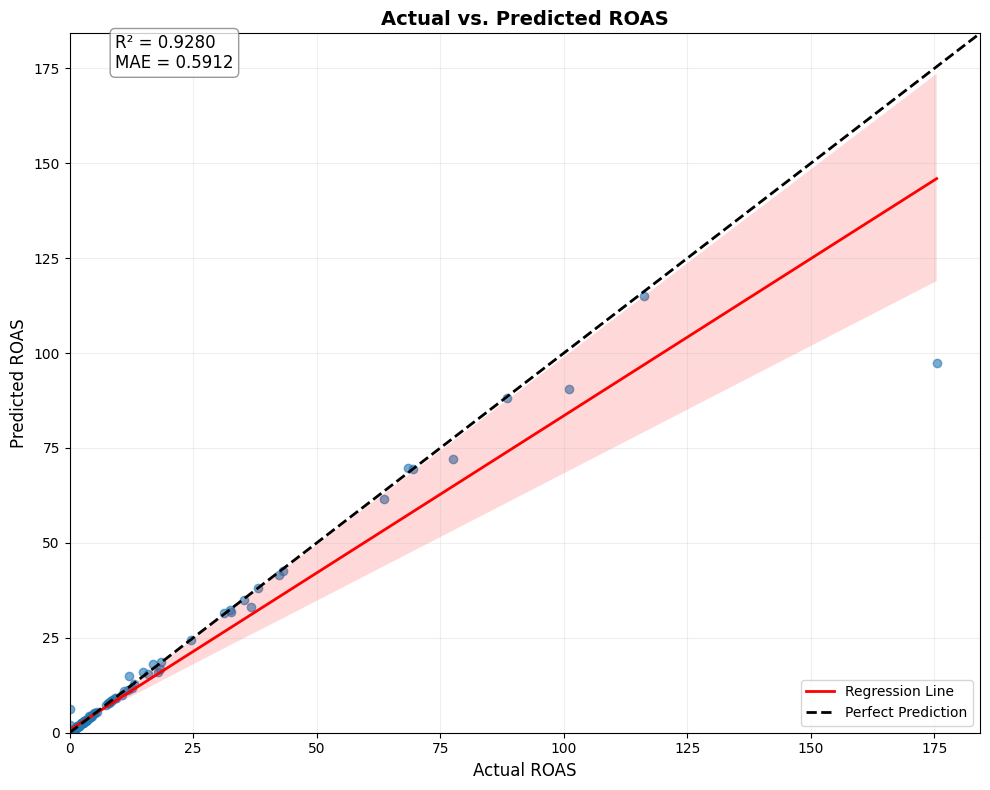

In [17]:
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Define X and y
exclude_cols = ['ad_id', 'xyz_campaign_id', 'fb_campaign_id']  # plus any columns you don't want as features
X = df_out.drop(columns=exclude_cols + ['ROAS'])  # assuming ROAS is your target
y = df_out['ROAS']


# Split data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Get the best model from grid search
best_model = grid.best_estimator_

# Make predictions
y_pred = best_model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Test MAE: {mae:.4f}')
print(f'Test R²: {r2:.4f}')

# Plot: Actual vs Predicted ROAS
plt.figure(figsize=(10, 8))

# Scatter plot with regression line
sns.regplot(
    x=y_test,
    y=y_pred,
    scatter_kws={'alpha': 0.6, 'color': '#1f77b4'},
    line_kws={'color': 'red', 'lw': 2, 'label': 'Regression Line'}
)

# Diagonal perfect prediction line
max_val = max(y_test.max(), y_pred.max()) * 1.05
plt.plot([0, max_val], [0, max_val], 'k--', lw=2, label='Perfect Prediction')

# Axis labels and title
plt.xlabel('Actual ROAS', fontsize=12)
plt.ylabel('Predicted ROAS', fontsize=12)
plt.title('Actual vs. Predicted ROAS', fontsize=14, fontweight='bold')

# Annotate R²
plt.annotate(f'R² = {r2:.4f}\nMAE = {mae:.4f}',
             xy=(0.05, 0.95),
             xycoords='axes fraction',
             fontsize=12,
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

plt.xlim(0, max_val)
plt.ylim(0, max_val)
plt.grid(alpha=0.2)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

#Refram Project 


In [38]:
# A/B Test Preparation
campaign_916 = df[df['xyz_campaign_id'] == 916]
campaign_936 = df[df['xyz_campaign_id'] == 936]

# Key Metrics Comparison
metrics = ['ROAS', 'CPC', 'Approved_Conversion']
report_data = pd.DataFrame({
    'Campaign 916': campaign_916[metrics].mean(),
    'Campaign 936': campaign_936[metrics].mean()
})

# Statistical A/B testing
from scipy import stats

def perform_ab_test(group_a, group_b, metric):
    t_stat, p_val = stats.ttest_ind(group_a[metric].dropna(), 
                                   group_b[metric].dropna())
    return {
        'p-value': p_val,
        'Significant?': p_val < 0.05
    }

ab_results = {}
for metric in metrics:
    ab_results[metric] = perform_ab_test(campaign_916,campaign_936, metric)

print(ab_results)

{'ROAS': {'p-value': 0.8048784783403038, 'Significant?': False}, 'CPC': {'p-value': 0.8765151165371932, 'Significant?': False}, 'Approved_Conversion': {'p-value': 0.5162474682321267, 'Significant?': False}}


In [39]:
# Define campaigns to compare
campaign_ids = [916, 936, 1178]
metrics = ['ROAS', 'CPC', 'Approved_Conversion']

# Create a dictionary of campaign DataFrames
campaign_data = {
    cid: df[df['xyz_campaign_id'] == cid] for cid in campaign_ids
}

from scipy import stats
import itertools

# Function to perform t-test between two groups
def perform_ab_test(group_a, group_b, metric):
    t_stat, p_val = stats.ttest_ind(group_a[metric].dropna(), group_b[metric].dropna())
    return {
        'p-value': round(p_val, 4),
        'Significant?': p_val < 0.05
    }

# Create all pairwise comparisons
pairwise_comparisons = list(itertools.combinations(campaign_ids, 2))

# Store results
ab_results = {}

for metric in metrics:
    ab_results[metric] = {}
    for cid1, cid2 in pairwise_comparisons:
        key = f"{cid1} vs {cid2}"
        ab_results[metric][key] = perform_ab_test(campaign_data[cid1], campaign_data[cid2], metric)

# Print the results
import pprint
pprint.pprint(ab_results)

{'Approved_Conversion': {'916 vs 1178': {'Significant?': True,
                                         'p-value': 0.0016},
                         '916 vs 936': {'Significant?': False,
                                        'p-value': 0.5162},
                         '936 vs 1178': {'Significant?': True, 'p-value': 0.0}},
 'CPC': {'916 vs 1178': {'Significant?': True, 'p-value': 0.0},
         '916 vs 936': {'Significant?': False, 'p-value': 0.8765},
         '936 vs 1178': {'Significant?': True, 'p-value': 0.0}},
 'ROAS': {'916 vs 1178': {'Significant?': True, 'p-value': 0.0},
          '916 vs 936': {'Significant?': False, 'p-value': 0.8049},
          '936 vs 1178': {'Significant?': True, 'p-value': 0.0}}}


In [40]:
for cid in campaign_ids:
    print(f"Campaign {cid}:")
    print(df[df['xyz_campaign_id'] == cid][metrics].mean())


Campaign 916:
ROAS                   12.592628
CPC                     0.862264
Approved_Conversion     0.444444
dtype: float64
Campaign 936:
ROAS                   11.353330
CPC                     0.846742
Approved_Conversion     0.394397
dtype: float64
Campaign 1178:
ROAS                   3.212014
CPC                    1.542302
Approved_Conversion    1.395200
dtype: float64


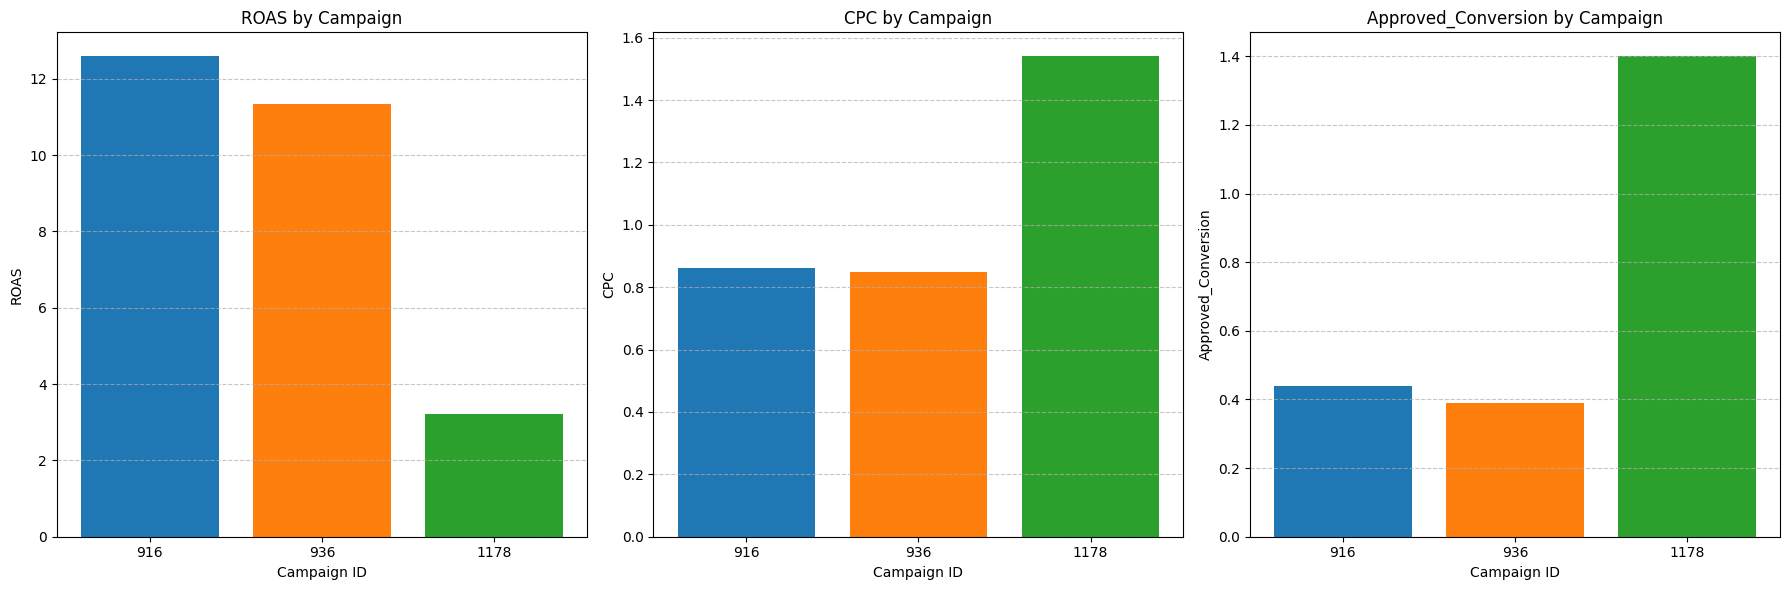

In [41]:
import matplotlib.pyplot as plt
import pandas as pd

# Data from your A/B test results
campaigns = ['916', '936', '1178']
metrics = ['ROAS', 'CPC', 'Approved_Conversion']
data = {
    '916': {'ROAS': 12.59, 'CPC': 0.86, 'Approved_Conversion': 0.44},
    '936': {'ROAS': 11.35, 'CPC': 0.85, 'Approved_Conversion': 0.39},
    '1178': {'ROAS': 3.21, 'CPC': 1.54, 'Approved_Conversion': 1.40}
}

# Convert to DataFrame for easy plotting
plot_data = pd.DataFrame(data).T

# Create the visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, metric in enumerate(metrics):
    axes[i].bar(plot_data.index, plot_data[metric], color=['#1f77b4', '#ff7f0e', '#2ca02c'])
    axes[i].set_title(f'{metric} by Campaign')
    axes[i].set_xlabel('Campaign ID')
    axes[i].set_ylabel(metric)
    axes[i].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()
